In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers

## for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from time import time
from gensim.models.phrases import Phrases, Phraser
import spacy  # For preprocessing
import en_core_web_sm

## for bag-of-words
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing

## for explainer
from lime import lime_text

## for word embedding
import gensim
import gensim.downloader as gensim_api

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\15714\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\15714\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\15714\anaconda3\envs\cds490\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.1). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [30]:
df = pd.read_csv('data_cleaned.csv',index_col=0)
df.columns

Index(['created_at', 'text', 'is_quote_status', 'has_description',
       'word_count', 'retweet_count', 'favorite_count', 'possibly_sensitive',
       'user.name', 'user.screen_name', 'user.location', 'user.description',
       'user.followers_count', 'user.friends_count', 'user.listed_count',
       'user.created_at', 'user.favourites_count', 'user.statuses_count',
       'user.profile_background_image_url',
       'user.profile_background_image_url_https', 'user.profile_banner_url',
       'real', 'hashtags', 'user', 'hash_count', 'mentions_count'],
      dtype='object')

In [27]:
df['text']

0           Activation of the SARS coronavirus 2 revealed 
1            More Vitamin D, Lower Risk of Severe COVID-\n
2         What’s the point in contact tracing if you wi...
3        Thank u life for deciding to break my macbook ...
4        COVID-ALERT New York woman beats coronavirus, ...
                               ...                        
10673    RT  oh my god Namjoon please no put down the c...
10674                                        -Michigan s… 
10675        How can we have testing kits prepared for ...
10676    \n“We’ve tested more than every country combin...
10677         - Thousands of Muslims in NJ cheered on \...
Name: text, Length: 10678, dtype: object

In [3]:
nlp = en_core_web_sm.load()

nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])
#https://spacy.io/usage/linguistic-features
    #Text: The original word text.
    #Lemma: The base form of the word.
    #POS: The simple UPOS part-of-speech tag.
    #Tag: The detailed part-of-speech tag.
    #Dep: Syntactic dependency, i.e. the relation between tokens.
    #Shape: The word shape – capitalization, punctuation, digits.
    #is alpha: Is the token an alpha character?
    #is stop: Is the token part of a stop list, i.e. the most common words of the language?

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

    
# re - regex sub    
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['text'])

C:\Users\15714\anaconda3\envs\cds490\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.2.0) requires spaCy v2.2 and is incompatible with the current spaCy version (2.3.1). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


In [4]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.11 mins


In [28]:
txt

['activation sars coronavirus reveal',
 'vitamin d low risk severe covid',
 '  s point contact trace willfully refuse ask attend mass gathering people',
 'thank u life decide break macbook air right town',
 "covid alert new york woman beat coronavirus celebrate th birthday ' remarkable ' global pande",
 'wear damn mask child wear child coronavirus neurological instead o',
 'hydroxychloroquine remdesivir combo dangerous covid patient fda',
 'med school bring student flood applicant',
 '  jesus christ lmao mean wild animal ve near domesticated one',
 'fourth july meet current surge covid case houston place safe home',
 'effective thermal scanner detect people infect new coronavirus',
 'wednesdaywisdom clean disinfect home cdc recommend ensure good',
 'vacancy recruit senior health care social care public health professional academic w',
 'fact prolonged use medical mask properly wear cause intoxication oxygen deficiency',
 '  get to hit year pay specialist appointment',
 'combination dru

In [5]:
from gensim.models.phrases import Phrases, Phraser
df_clean = pd.DataFrame({'text':df['text'],'text_clean':txt,'real':df['real']})
df_clean.dropna(subset=['text_clean'],inplace=True)

In [6]:
## split dataset
df_train, df_test = model_selection.train_test_split(df_clean, test_size=0.3)
## get target
y_train = df_train["real"].values
y_test = df_test["real"].values

In [7]:
tweets_train = df_train['text_clean']
tweets_test = df_test['text_clean']

In [8]:
y = df_train['real']

In [9]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(tweets_train))
list_tokenized_train = tokenizer.texts_to_sequences(tweets_train)
list_tokenized_test = tokenizer.texts_to_sequences(tweets_test)

In [10]:
tokenizer.word_counts

OrderedDict([('widespread', 12),
             ('adoption', 4),
             ('key', 33),
             ('safe', 48),
             ('secure', 5),
             ('election', 5),
             ('state', 89),
             ('fail', 13),
             ('plan', 35),
             ('congress', 8),
             ('provide', 36),
             ('vitamin', 180),
             ('c', 222),
             ('protect', 217),
             ('coronavirus', 2391),
             ('greenmedinfo', 7),
             ('blog', 16),
             ('entry', 15),
             ('cannabi', 19),
             ('stop', 118),
             ('infect', 57),
             ('people', 338),
             ('study', 249),
             ('find', 158),
             ('coronavi', 4),
             ('refrigerator', 1),
             ('nice', 7),
             ('cleaning', 32),
             ('disinfect', 27),
             ('glad', 5),
             ('assist', 10),
             ('affordable', 3),
             ('house', 23),
             ('amp', 275),
   

In [11]:
list_tokenized_train[:1]

[[783, 1659, 341, 237, 1436, 1437, 140, 740, 322, 1045, 740, 315]]

In [12]:
# need to make vectors the same size
maxlen = 200
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [13]:
# how do we know to use 200 as max length of vectors?
# see distribution of number of words in comments
total_wordcount = [len(one_comment) for one_comment in list_tokenized_train]

(array([4339., 2844.,   27.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390, 400]),
 <BarContainer object of 40 artists>)

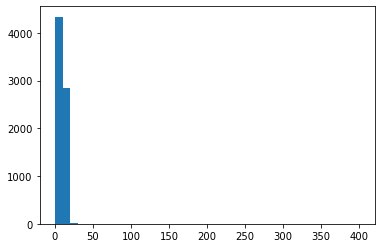

In [14]:
# view sentence length distribution
plt.hist(total_wordcount, bins = np.arange(0,410,10))

In [15]:
inp = Input(shape=(maxlen,))

embed_size = 128
x = Embedding(max_features,embed_size)(inp)

x = LSTM(10, return_sequences=True,name='lstm_layer')(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.1)(x)
x = Dense(9,activation='relu')(x)

x = Dropout(0.1)(x)
x = Dense(1,activation='sigmoid')(x)

model = Model(inputs=inp,outputs=x)
model.compile(loss='binary_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [16]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',verbose=1,patience=3)

In [17]:
batch_size = 32
epochs = 100
model.fit(X_train,y,batch_size=batch_size,epochs=epochs,validation_split=0.1,callbacks=[early_stop])

Epoch 1/100
203/203 [==============================] - 12s 59ms/step - loss: 0.4009 - accuracy: 0.8453 - val_loss: 0.1307 - val_accuracy: 0.9598
Epoch 2/100
203/203 [==============================] - 11s 54ms/step - loss: 0.0999 - accuracy: 0.9678 - val_loss: 0.1119 - val_accuracy: 0.9556
Epoch 3/100
203/203 [==============================] - 10s 52ms/step - loss: 0.0404 - accuracy: 0.9911 - val_loss: 0.1301 - val_accuracy: 0.9487
Epoch 4/100
203/203 [==============================] - 10s 51ms/step - loss: 0.0206 - accuracy: 0.9954 - val_loss: 0.1438 - val_accuracy: 0.9570
Epoch 5/100
203/203 [==============================] - 11s 53ms/step - loss: 0.0111 - accuracy: 0.9974 - val_loss: 0.1911 - val_accuracy: 0.9515
Epoch 00005: early stopping


<AxesSubplot:>

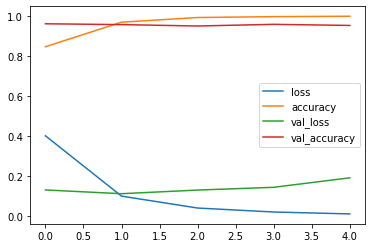

In [18]:
model_loss = pd.DataFrame(model.history.history)
model_loss.plot()

In [19]:
predicted_prob = model.predict(X_test)
predicted_prob

array([[9.9986279e-01],
       [9.9989414e-01],
       [2.6524067e-04],
       ...,
       [9.9963361e-01],
       [9.9986130e-01],
       [2.5382638e-04]], dtype=float32)

In [20]:
predicted = [] #create binary values

for x in predicted_prob:
    if x < .5:
        predicted.append(0)
    elif x >= .5:
        predicted.append(1)

In [21]:
predicted

[1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,


In [22]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(y_test,predicted))
print(confusion_matrix(y_test,predicted))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94      1528
           1       0.94      0.95      0.95      1562

    accuracy                           0.95      3090
   macro avg       0.95      0.95      0.95      3090
weighted avg       0.95      0.95      0.95      3090

[[1434   94]
 [  73 1489]]


In [23]:
model.save('solis_model.h5')